# 4.1. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

### Enlaces

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Tutorial: Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
import transformers
from   torch import nn
from   torch.optim import Adam
    
import logging

from data.fashion import load_datasets
import data  as dt
import model as ml

import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-11-14 11:03:10,277 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
ut.set_seed(42)

Definimos el modelo preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
# MODEL_NAME ='bert-base-cased'
MODEL_NAME ='bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{MODEL_NAME}.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set, val_set, test_set = load_datasets(DATASET_PATH, prefix='bert_')

In [15]:
train_set['tokens_count'] = train_set['features'].apply(lambda x: len(x.split(' ')))
val_set['tokens_count']   = val_set['features'].apply(lambda x: len(x.split(' ')))
test_set['tokens_count']  = test_set['features'].apply(lambda x: len(x.split(' ')))

In [16]:
max_tokens_count = max([train_set['tokens_count'].max(), val_set['tokens_count'].max(), test_set['tokens_count'].max()])
max_tokens_count

35

Tamaño máximo de la secuencia de entrada:

In [17]:
tokens_count = 2 + max_tokens_count
tokens_count

37

Definimos el tokenizer y los dataset para tran, validation y test:

In [18]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(MODEL_NAME), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [19]:
train_dataset = dt.Dataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

190

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

190

In [22]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        MODEL_NAME, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0,
    hiden_state_dim = 768
)

## Entrenamiento

In [23]:
if TRAIN:
    model = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())

In [24]:
if TRAIN:
    LR     = 0.00001
    EPOCHS = 8

    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-11-14 11:08:10,545 - INFO - Time: 0:03:40.85 | Epoch: 1 | Train(loss: 0.062009, acc: 55.15%) | Val(loss: 0.033193, acc: 71.22%) | acc diff: 16.07%
2022-11-14 11:11:51,140 - INFO - Time: 0:03:40.59 | Epoch: 2 | Train(loss: 0.027927, acc: 73.92%) | Val(loss: 0.024769, acc: 75.81%) | acc diff: 1.89%
2022-11-14 11:15:32,417 - INFO - Time: 0:03:41.28 | Epoch: 3 | Train(loss: 0.022410, acc: 77.32%) | Val(loss: 0.022149, acc: 77.86%) | acc diff: 0.54%
2022-11-14 11:19:13,237 - INFO - Time: 0:03:40.82 | Epoch: 4 | Train(loss: 0.019913, acc: 78.87%) | Val(loss: 0.020710, acc: 78.04%) | acc diff: 0.83%
2022-11-14 11:22:53,910 - INFO - Time: 0:03:40.67 | Epoch: 5 | Train(loss: 0.018229, acc: 80.09%) | Val(loss: 0.019848, acc: 79.26%) | acc diff: 0.83%
2022-11-14 11:26:34,888 - INFO - Time: 0:03:40.98 | Epoch: 6 | Train(loss: 0.016731, acc: 81.43%) | Val(loss: 0.019529, acc: 79.35%) | acc diff: 2.08%
2022-11-14 11:30:15,694 - INFO - Time: 0:03:40.81 | Epoch: 7 | Train(loss: 0.015451, acc: 82.

In [26]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [27]:
classifier.load(MODEL_WEIGHTS_PATH)

In [28]:
model   = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())
summary = model.validate(test_dataset)
summary.show()

Accuracy: 81.50%, Loss: 0.016996


Guardamos target y predicciones:

In [41]:
label_by_class_dict = label_by_class(test_set)

pd.DataFrame({
    'prediction': [label_by_class_dict[e] for e in np.concatenate(summary.predictions)],
    'target'     : [label_by_class_dict[e] for e in np.concatenate(summary.targets)]
}).to_csv(f'{DATASET_PATH}/bert-pred-target.csv', index=False)

In [30]:
np.array(summary.targets).shape

(2848,)

                                                               precision    recall  f1-score   support

                                        accessories~belts~n/d       0.97      0.96      0.96       146
                             accessories~hair accessories~n/d       0.74      0.90      0.81        39
                                         accessories~hats~n/d       0.97      0.99      0.98       254
                    accessories~phone, computer & gadgets~n/d       0.51      0.82      0.63        39
                                      accessories~scarves~n/d       0.99      0.98      0.99      2000
                                   accessories~sunglasses~n/d       1.00      0.99      0.99       186
                              accessories~ties & bow ties~n/d       0.90      0.95      0.93        20
                        accessories~wallets & cardholders~n/d       0.68      0.78      0.72        32
                             accessories~wallets & purses~n/d       0.51

<Figure size 4500x4500 with 2 Axes>

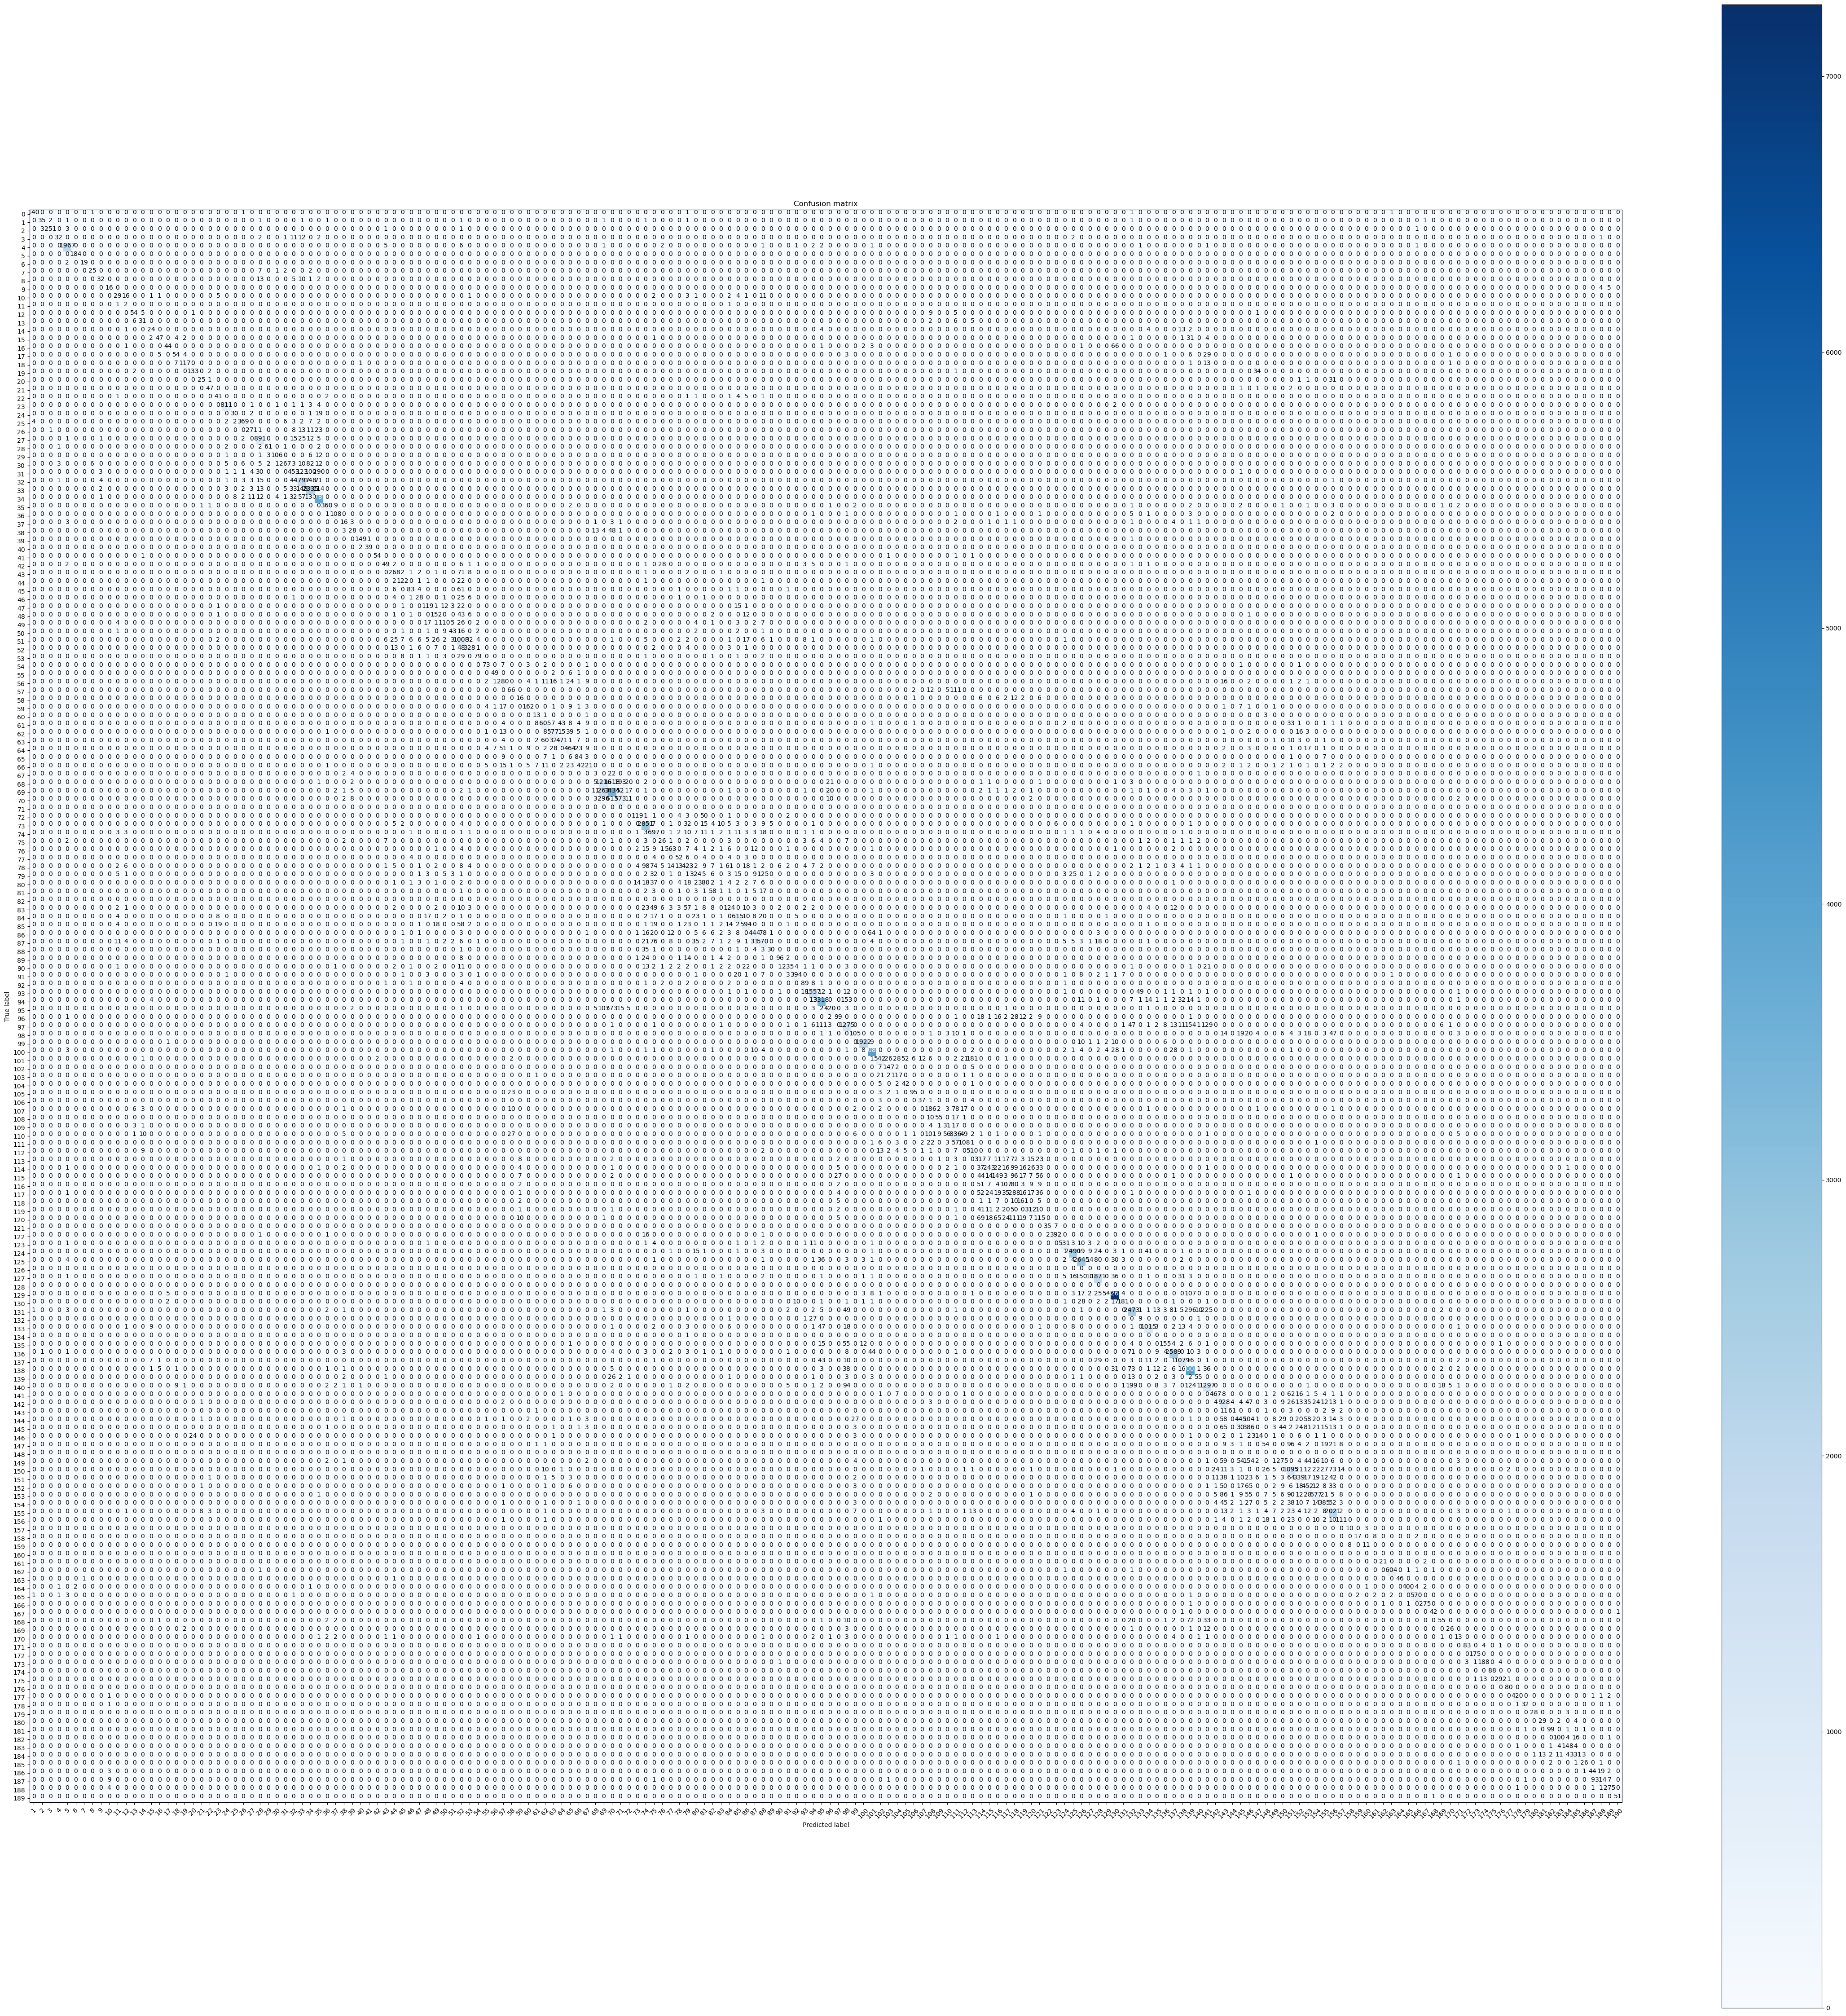

In [49]:
summary.plot_metrics(label_by_class = label_by_class(train_set), figuresize=(45, 45))

In [32]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bert-model-fail-report.csv', index=False)

Total Fails: 18.20%


Determinamos cuales son las clases con bajo **f1-score**:

In [33]:
less_than_f1_score = 0.5
    
worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((3543, 5), (113884, 14))

In [34]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
12817,description : floral crochet midi dress. gender : women. brand : marco rambaldi. materials : cotton linen / flax.,clothing~dresses~beach dresses,,clothing~knitwear~knitted dresses,
1726,description : graphic - print cotton t - shirt. gender : men. brand : ih nom uh nit. materials : cotton.,clothing~t-shirts & vests~n/d,,clothing~t-shirts & vests~t-shirts,
8814,description : distressed open - knit midi dress. gender : women. brand : dion lee. materials : viscose linen / flax.,clothing~dresses~evening dresses,,clothing~dresses~day dresses,
19457,description : draped abstract - print skirt. gender : women. brand : msgm. materials : cotton.,clothing~skirts~high-waisted skirts,,clothing~skirts~asymmetric & draped skirts,
12768,description : ruffle high - low hem dress. gender : women. brand : saiid kobeisy. materials : polyester.,clothing~dresses~n/d,,clothing~dresses~cocktail & party dresses,
5558,description : striped mini skirt. gender : women. brand : alessandra rich. materials : cotton polyester acrylic polyamide viscose.,clothing~skirts~high-waisted skirts,,clothing~skirts~fitted skirts,
9759,description : descendents quilted jacket. gender : men. brand : moose knuckles. materials : recycled nylon.,activewear~performance jackets~lightweight jackets,,clothing~jackets~padded & down jackets,


In [35]:
less_than_f1_score = 0.27

worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((418, 5), (113884, 14))

In [36]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
6080,description : 18kt yellow gold babylon love pendant necklace. gender : women. brand : julien riad sahyoun. materials : diamond 18kt yellow gold tsavorite,fine jewellery~fine necklaces~n/d,,demi-fine jewellery~demi-fine necklaces~n/d,
2275,description : couture logo plaque t - shirt. gender : men. brand : moschino. materials : elastane cotton.,clothing~t-shirts & vests~n/d,,clothing~t-shirts & vests~t-shirts,
11662,description : pinstripe cigarette suit trousers. gender : women. brand : manuel ritz. materials : polyester elastane viscose wool.,clothing~trousers~n/d,,clothing~trousers~tailored trousers,
17797,description : cameron high - rise tailored trousers. gender : women. brand : anna quan. materials : polyester wool.,clothing~trousers~n/d,,clothing~trousers~tailored trousers,
13664,description : ruched press - stud top. gender : women. brand : alexander wang. materials : elastane polyamide.,clothing~tops~cardigans,,clothing~tops~blouses,
5694,description : balloon - leg cargo trousers. gender : women. brand : nili lotan. materials : cotton elastane.,clothing~trousers~n/d,,clothing~trousers~tapered trousers,
4358,description : edith pleated strappy dress. gender : women. brand : temperley london. materials : mother of pearl cotton.,clothing~dresses~n/d,,clothing~dresses~evening dresses,


In [37]:
branch_by_seq = {r['branch_seq']: r['branch'] for _, r in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows()}

branch_predictions = [branch_by_seq[e] for e in np.concatenate(summary.predictions)]
branch_targets     = [branch_by_seq[e] for e in np.concatenate(summary.targets)]

family_predictions = [e.split('~')[0] for e in branch_predictions]
family_targets     = [e.split('~')[0] for e in branch_targets]

category_predictions = [e.split('~')[1] for e in branch_predictions]
category_targets     = [e.split('~')[1] for e in branch_targets]

subcategory_predictions = [e.split('~')[2] for e in branch_predictions]
subcategory_targets     = [e.split('~')[2] for e in branch_targets]

                      precision    recall  f1-score   support

         accessories       0.96      0.98      0.97      2759
          activewear       0.68      0.76      0.72       961
                bags       1.00      0.99      1.00     12997
            clothing       1.00      0.99      1.00     91987
 demi-fine jewellery       0.68      0.73      0.70        37
      fine jewellery       0.76      0.68      0.72        47
           jewellery       0.99      0.99      0.99      1959
lingerie & nightwear       0.33      0.59      0.43       160
           pre-owned       1.00      1.00      1.00       938
               shoes       0.99      0.99      0.99      1987
             watches       0.98      0.98      0.98        52

            accuracy                           0.99    113884
           macro avg       0.85      0.88      0.86    113884
        weighted avg       0.99      0.99      0.99    113884



<Figure size 600x600 with 2 Axes>

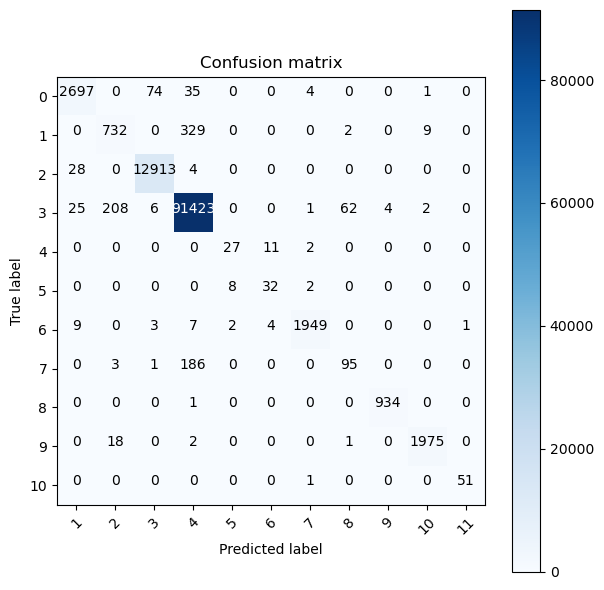

In [42]:
ml.plot_metrics(family_targets, family_predictions, figuresize=(6, 6))

                            precision    recall  f1-score   support

                all in one       0.93      0.95      0.94       505
                 backpacks       0.98      0.98      0.98       827
                beach bags       0.58      0.73      0.65        41
                 beachwear       0.76      0.85      0.81       346
                 belt bags       0.93      0.96      0.94       386
                     belts       0.97      0.96      0.96       146
                    bodies       0.28      0.65      0.39        85
                     boots       0.99      0.99      0.99       424
                 bracelets       0.99      0.99      0.99       608
                      bras       0.58      0.76      0.66        34
           brooches & pins       0.96      1.00      0.98        46
               bucket bags       0.83      0.92      0.87       295
               clutch bags       0.94      0.90      0.92       995
                     coats       0.94      0.92

<Figure size 2000x2000 with 2 Axes>

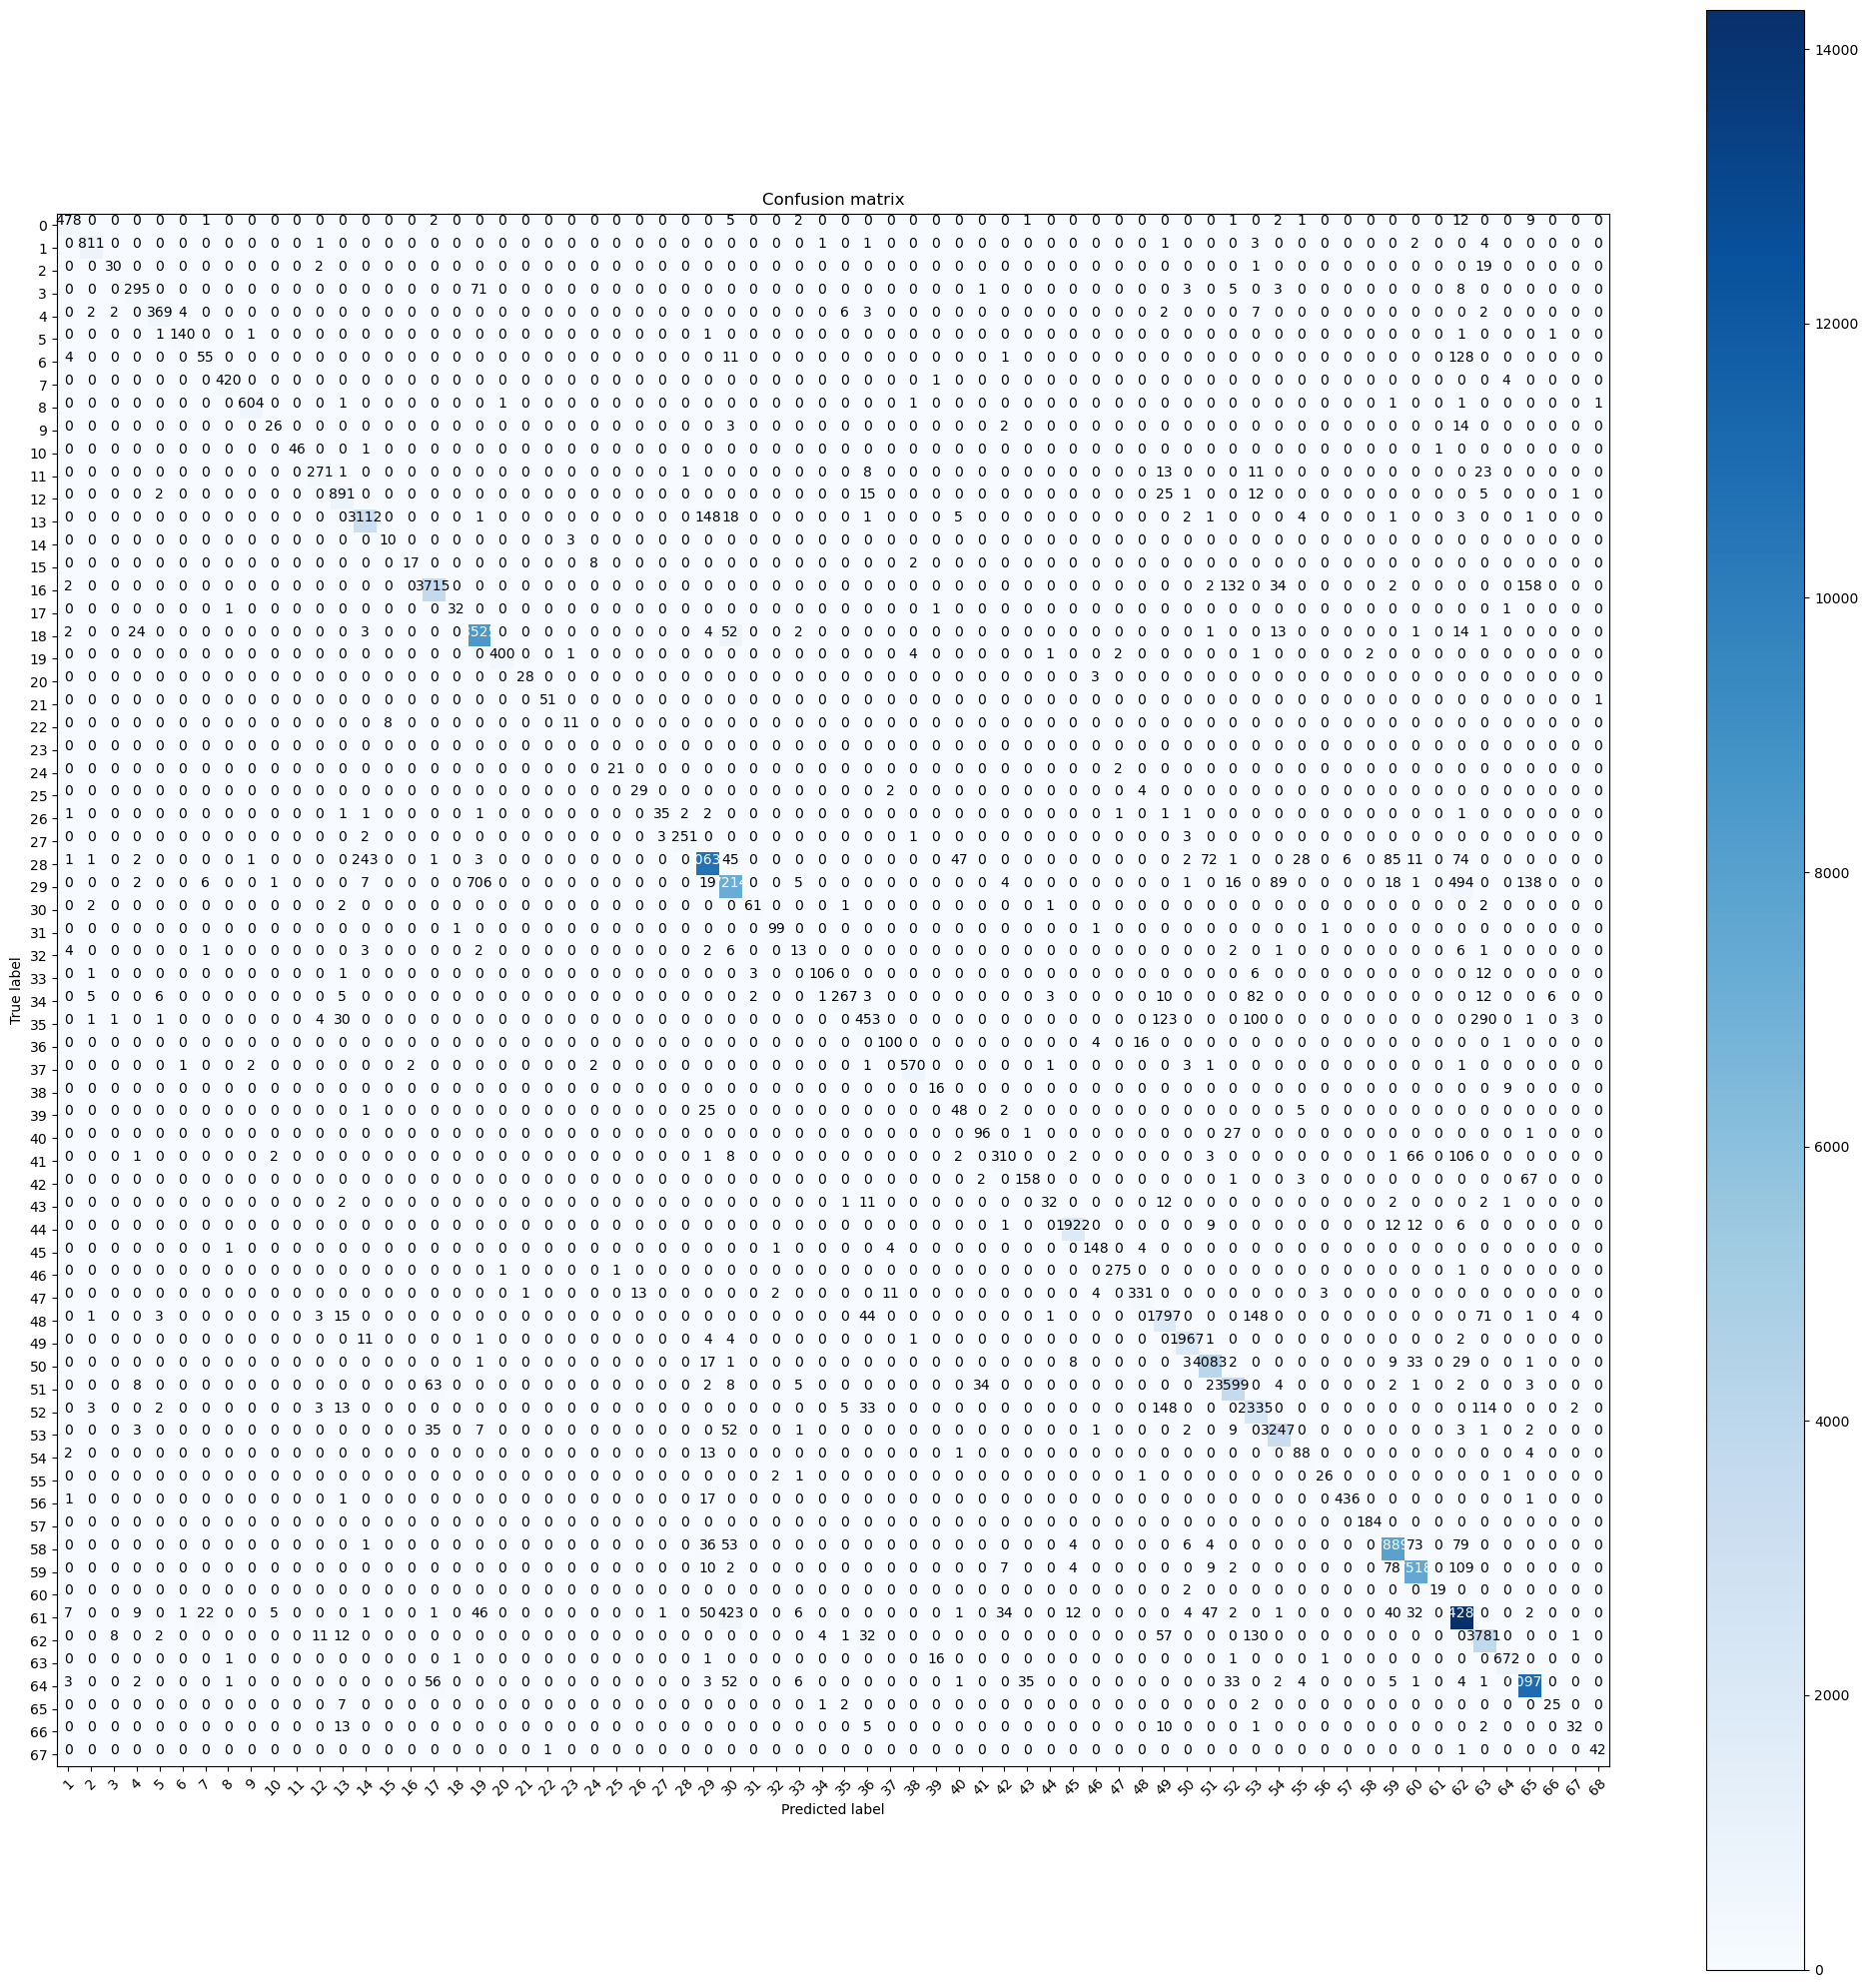

In [43]:
ml.plot_metrics(category_targets, category_predictions, figuresize=(20, 20))

                                   precision    recall  f1-score   support

                    a-line skirts       0.66      0.50      0.57       640
       asymmetric & draped skirts       0.48      0.74      0.58       329
                  beach cover-ups       0.41      0.36      0.38        45
                    beach dresses       0.37      0.52      0.43        93
                   bermuda shorts       0.61      0.89      0.73       606
                    biker jackets       0.66      0.84      0.74       142
                          bikinis       0.99      0.97      0.98       153
                          blazers       0.96      0.90      0.93      3165
                          blouses       0.78      0.84      0.81      2934
                   bomber jackets       0.88      0.66      0.75      1064
                    bootcut jeans       0.83      0.81      0.82        90
                  boyfriend jeans       0.84      0.84      0.84        58
                        

<Figure size 4000x4000 with 2 Axes>

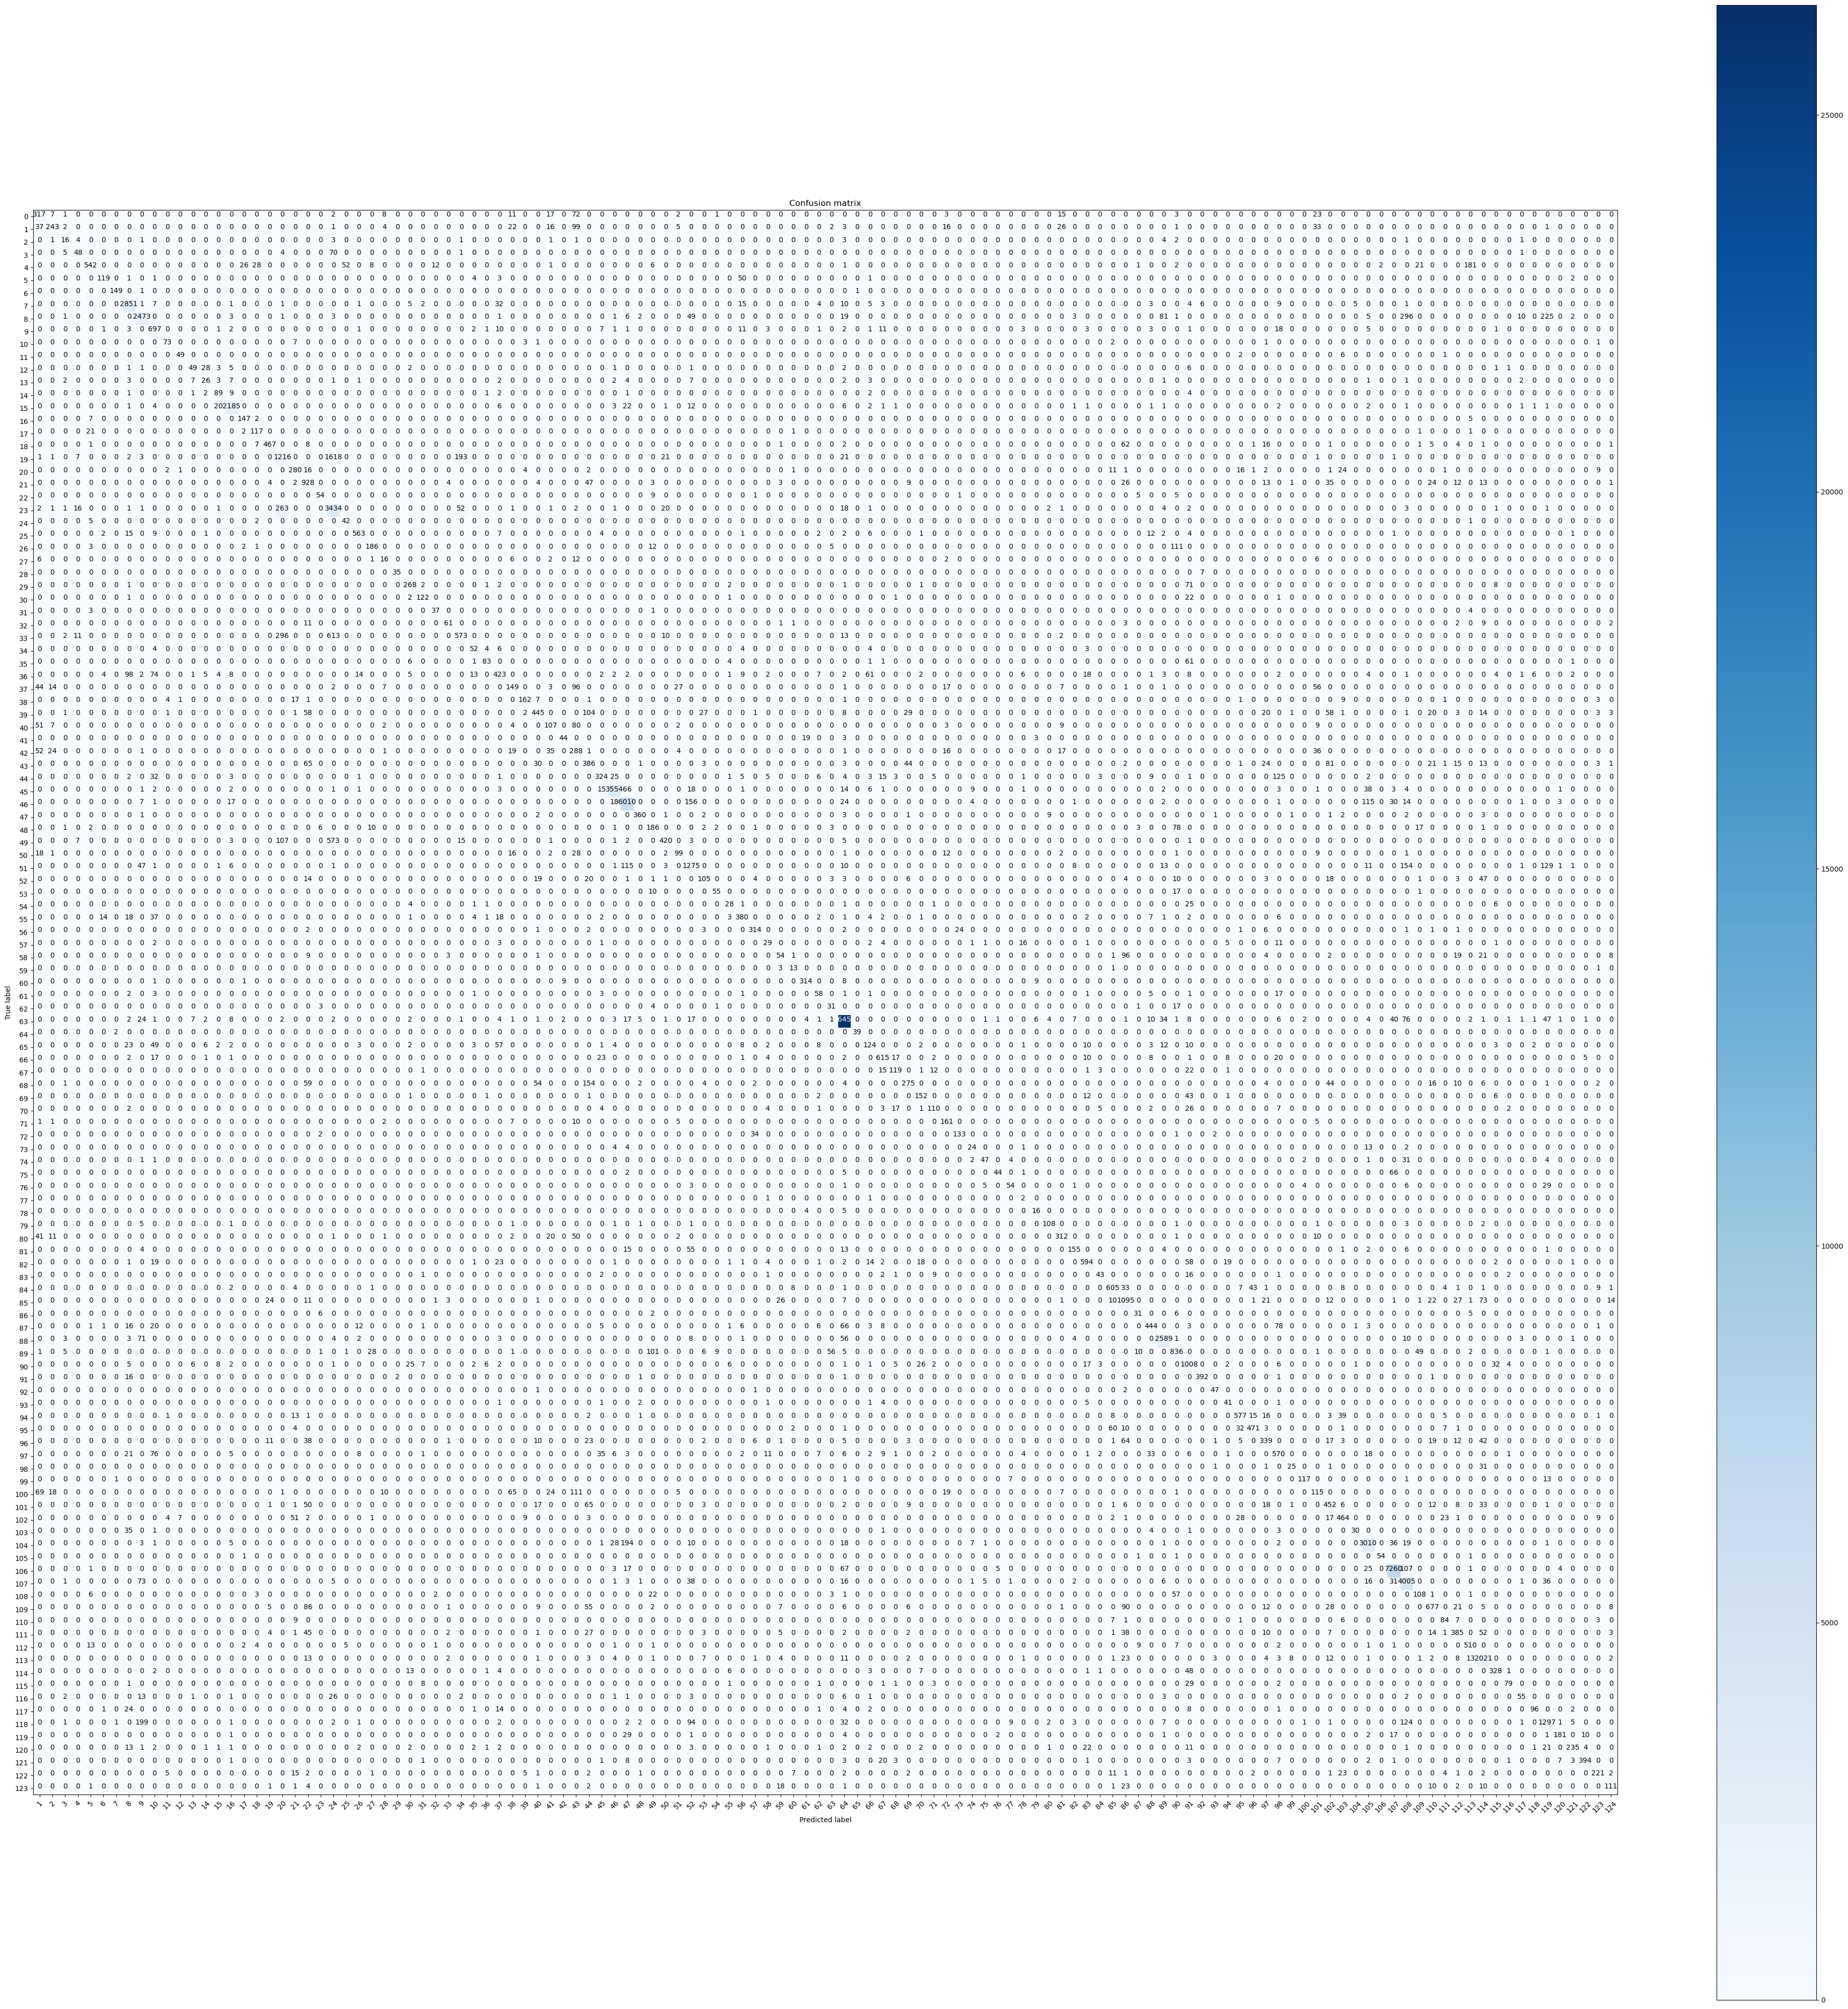

In [48]:
ml.plot_metrics(subcategory_targets, subcategory_predictions, figuresize=(40, 40))